# Data processing and exploration

A plot or two of the images/class balances should suffice

In [14]:
import pickle

train = 'C:/Users/Barotp/Downloads/traffic-signs-data/train.p'
test = 'C:/Users/Barotp/Downloads/traffic-signs-data/test.p'

with open(train, mode='rb') as f:
    train = pickle.load(f)
with open(test, mode='rb') as f:
    test = pickle.load(f)

# Get some details about dataset
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (39209, 32, 32, 3)
y_train shape: (39209,)
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


In [15]:
import numpy as np

n_train = len(X_train)

n_test = len(X_test)

image_shape = X_train[0].shape

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


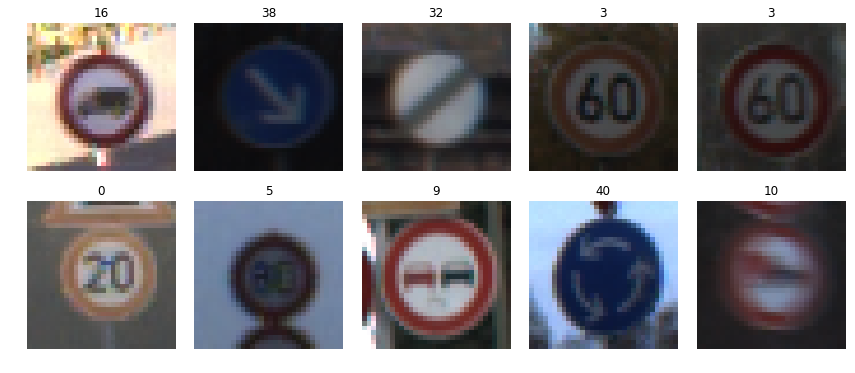

In [16]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

fig, axs = plt.subplots(2,5, figsize = (15,6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

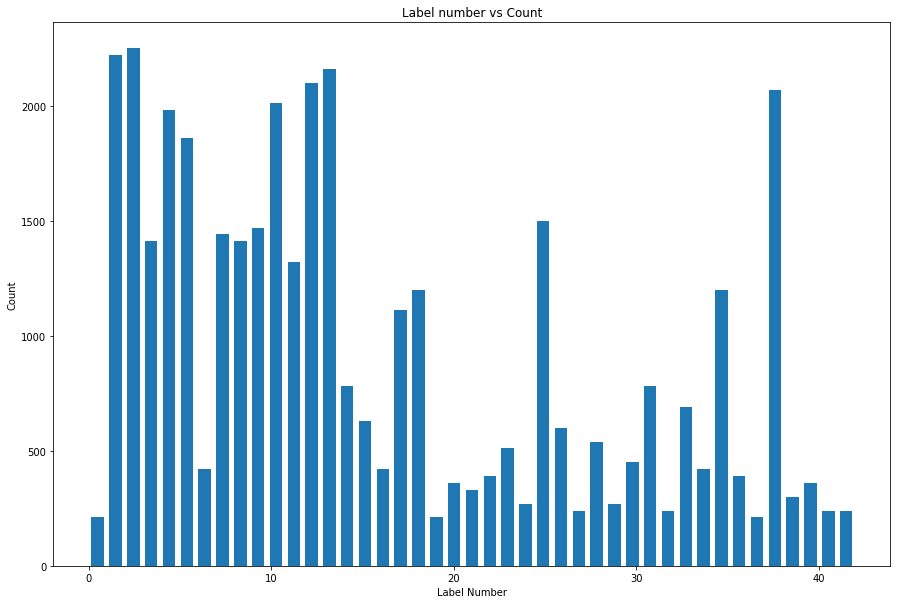

In [17]:
hist, bins = np.histogram(y_train, bins = n_classes)
width = 0.7* (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.figure(figsize=(15,10))

plt.bar(center, hist, align='center', width=width)
plt.xlabel("Label Number")
plt.ylabel("Count")
plt.title("Label number vs Count")
plt.show()

# Model development

A version of the LeNet-5 CNN architecture will be written, edited for this specific problem and tweaked as per my personal preferences

In [18]:
X_train_rgb = X_train
X_train_gry = np.sum(X_train/3, axis=3, keepdims=True)

X_test_rgb = X_test
X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)

print('RGB shape:', X_train_rgb.shape)
print('Grayscale shape:', X_train_gry.shape)

RGB shape: (39209, 32, 32, 3)
Grayscale shape: (39209, 32, 32, 1)


In [19]:
X_train = X_train_gry
X_test = X_test_gry

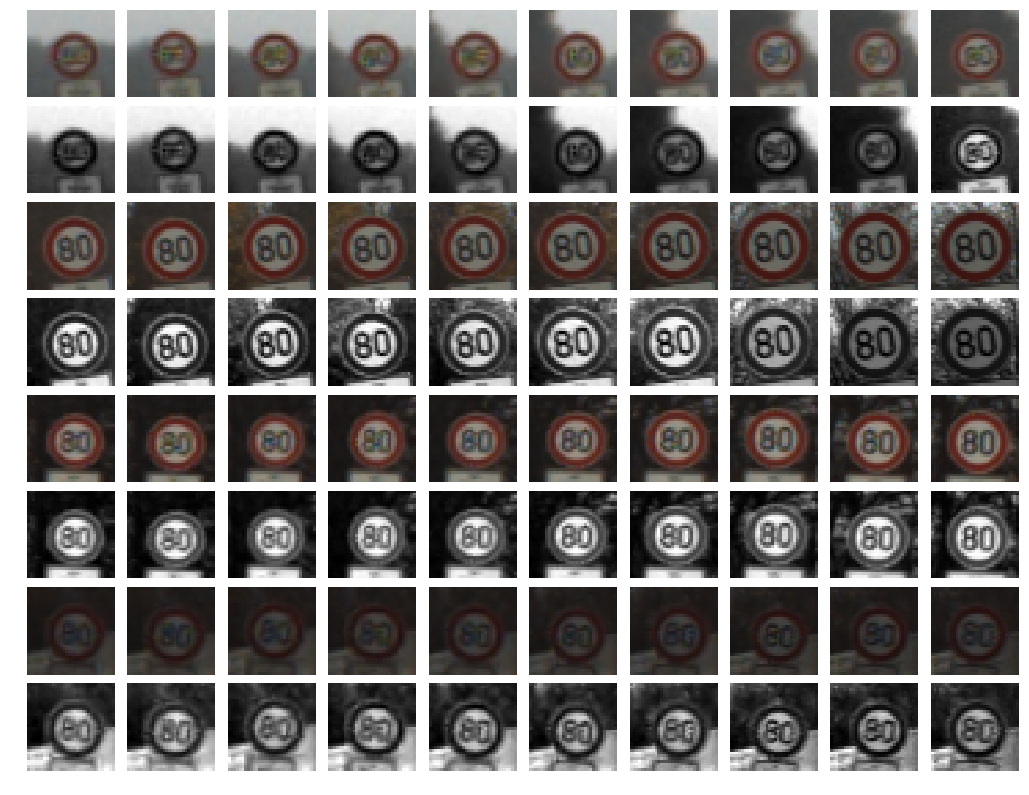

In [20]:
n_rows = 8
n_cols = 10
offset = 9000
fig, axs = plt.subplots(n_rows,n_cols, figsize=(18, 14))
fig.subplots_adjust(hspace = .1, wspace=.001)
axs = axs.ravel()

for j in range(0, n_rows, 2):
    for i in range(n_cols):
        index = i + j*n_cols
        image = X_train_rgb[index + offset]
        axs[index].axis('off')
        axs[index].imshow(image)
    for i in range(n_cols):
        index = i + j*n_cols + n_cols 
        image = X_train_gry[index + offset - n_cols].squeeze()
        axs[index].axis('off')
        axs[index].imshow(image, cmap='gray')

In [21]:
print(np.mean(X_train))
print(np.mean(X_test))

## normalizing to -1,1

X_train_normalized = (X_train - 128)/128 
X_test_normalized = (X_test - 128)/128

print(np.mean(X_train_normalized))
print(np.mean(X_test_normalized))

82.66505234601497
82.14846036120173
-0.3541792785467594
-0.3582151534281105


## Pre-processing steps

1. Greyscale images work well for the LeCun CNN architecture, reduces training time
2. Normalized the data to reduce distribution in the array values and allow for better training on a single learning rate

shape in/out: (32, 32, 1) (32, 32, 1)


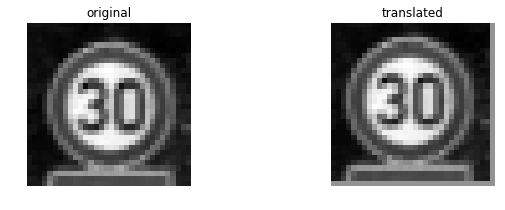

In [22]:
import cv2

def random_translate(img):
    rows,cols,_ = img.shape
    
    px = 2
    dx,dy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

test_img = X_train_normalized[500]

test_dst = random_translate(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('translated')

print('shape in/out:', test_img.shape, test_dst.shape)

shape in/out: (32, 32, 1) (32, 32, 1)


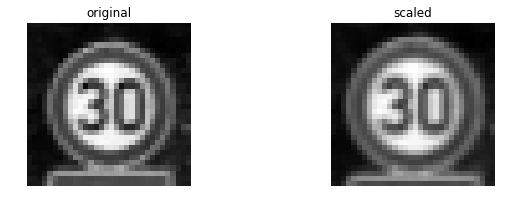

In [23]:
def random_scaling(img):   
    rows,cols,_ = img.shape

    px = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

test_dst = random_scaling(test_img)
    
fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('scaled')

print('shape in/out:', test_img.shape, test_dst.shape)


shape in/out: (32, 32, 1) (32, 32, 1)


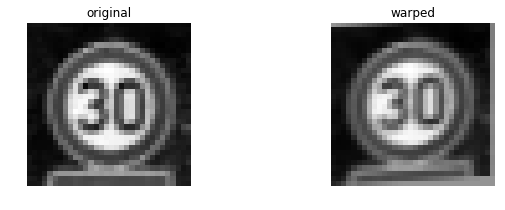

In [24]:
def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

test_dst = random_warp(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('warped')

print('shape in/out:', test_img.shape, test_dst.shape)

shape in/out: (32, 32, 1) (32, 32, 1)


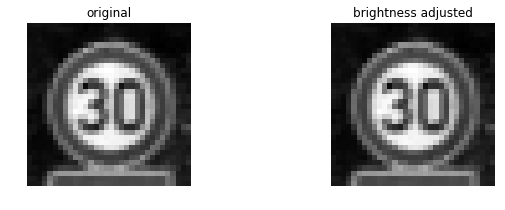

In [25]:
def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst

test_dst = random_brightness(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('brightness adjusted')

print('shape in/out:', test_img.shape, test_dst.shape)

In [26]:
print(np.bincount(y_train))
print("minimum class sample count", min(np.bincount(y_train)))

[ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160
  780  630  420 1110 1200  210  360  330  390  510  270 1500  600  240
  540  270  450  780  240  689  420 1200  390  210 2070  300  360  240
  240]
minimum class sample count 210


In [32]:
input_indices = []
output_indices = []

for class_n in range(n_classes):
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    if n_samples < 800:
        for i in range(800 - n_samples):
            input_indices.append(class_indices[0][i%n_samples])
            output_indices.append(X_train_normalized.shape[0])
            new_img = X_train_normalized[class_indices[0][i % n_samples]]
            new_img = random_translate(random_scaling(random_warp(random_brightness(new_img))))
            X_train_normalized = np.concatenate((X_train_normalized, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis = 0)
            if i%50 == 0:
                print('|', end='')
            elif i % 10 == 0:
                print('-',end='')
            
print('X, y shapes:', X_train_normalized.shape, y_train.shape)


|----|----|----|----|----|----|----|----|----|----|----|---|----|----|----|----|----|----|----|--|-|----|----|----|-|----|----|----|----|----|----|----|--|----|----|----|----|----|----|----|----|----|----|----|---|----|----|----|----|----|----|----|----|---|----|----|----|----|----|----|----|----|----|-|----|----|----|----|----|----|----|----||----|----|----|----|----|---|----|----|----|----|----|----|----|----|----|----|--|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----||----|----|----|----|----||----|----|----|----|----|----|----|----|----|----|--|----|----|----|----|----|----|----|-|----|----|----|----|----|----|----|----|----|----|----||----|----|-|----|----|----|----|----|----|----|--|----|----|----|----|----|----|----|----||----|----|----|----|----|----|----|----|----|----|----|---|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|---|----|----|----|----|----|----|----|----|----|----|----||----|----|----|----|----

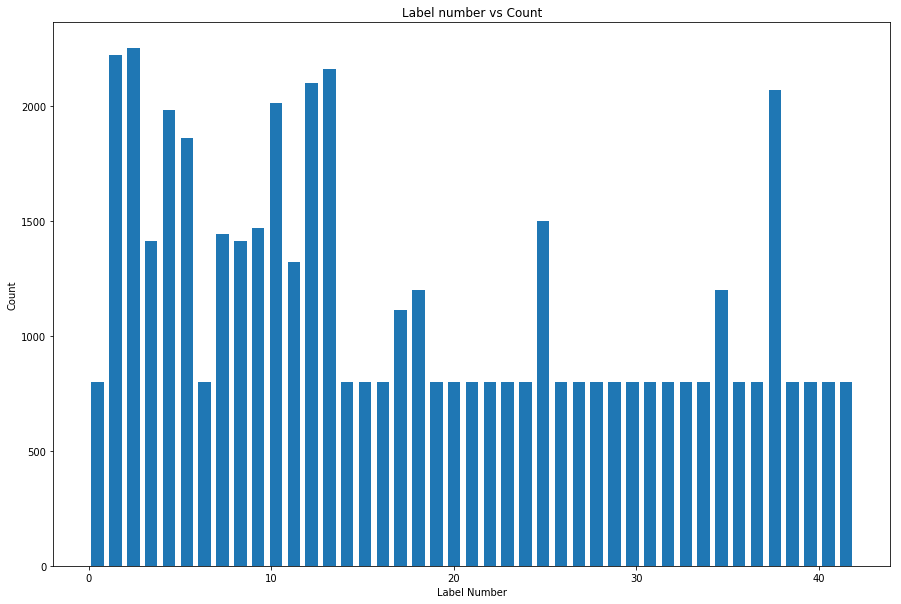

In [34]:
## new class counts, everything brought up to 800
hist, bins = np.histogram(y_train, bins = n_classes)
width = 0.7* (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.figure(figsize=(15,10))

plt.bar(center, hist, align='center', width=width)
plt.xlabel("Label Number")
plt.ylabel("Count")
plt.title("Label number vs Count")
plt.show()


In [35]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train_normalized, y_train = shuffle(X_train_normalized, y_train)

X_train, X_validation, y_train, y_validation = train_test_split(X_train_normalized, y_train, test_size = 0.33, random_state=42)

In [36]:
print("Old X_train size:",len(X_train_normalized))
print("New X_train size:",len(X_train))
print("X_validation size:",len(X_validation))

Old X_train size: 49510
New X_train size: 33171
X_validation size: 16339


## Model Building

In [39]:
import tensorflow as tf

EPOCHS = 60
BATCH_SIZE = 100

C:\Users\BarotP\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
from tensorflow.contrib.layers import flatten


def LeNet(x):
    